In [ ]:
import re, ast, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

np.random.seed(0)
pd.set_option("display.max_columns", 200)

DATA_PATH = "data/top_10000_1950-now.csv"   
OUT_FIG_DIR = "outputs/figures"
OUT_TAB_DIR = "outputs/tables"
os.makedirs(OUT_FIG_DIR, exist_ok=True)
os.makedirs(OUT_TAB_DIR, exist_ok=True)

FEATURES_RAW = ["Danceability", "Energy", "Tempo", "duration_min"]
MIN_N_CELL = 5
GENRE_ORDER = [
    "Pop",
    "Rock",
    "Hip-Hop",
    "R&B/Soul",
    "Electronic",
    "Country",
    "Oldies/Standards",
    "Other",
]

MERGE_LATIN_TO_OTHER = True


In [ ]:
songs = pd.read_csv(DATA_PATH).copy()

songs["year"] = (
    songs["Album Release Date"]
    .astype(str)
    .str.strip()
    .str[:4]
)


songs["year"] = pd.to_numeric(songs["year"], errors="coerce")

# Drop rows with no valid year
songs = songs.dropna(subset=["year"]).copy()
songs["year"] = songs["year"].astype(int)
songs = songs[(songs["year"] >= 1950) & (songs["year"] <= 2025)].copy()
songs["decade"] = (songs["year"] // 10) * 10


songs["duration_min"] = songs["Track Duration (ms)"] / 60000.0

# Keep analysis range
songs = songs[(songs["decade"] >= 1950) & (songs["decade"] <= 2010)].copy()

# Drop rows missing audio features
songs = songs.dropna(
    subset=["Danceability", "Energy", "Tempo", "duration_min"]
).copy()

songs = songs.sort_values("year").drop_duplicates(
    subset=["Track URI"],
    keep="first"
).copy()

songs.shape


(9343, 38)

count    9343.000000
mean     2000.753398
std        14.937284
min      1955.000000
25%      1992.000000
50%      2005.000000
75%      2012.000000
max      2019.000000
Name: year, dtype: float64


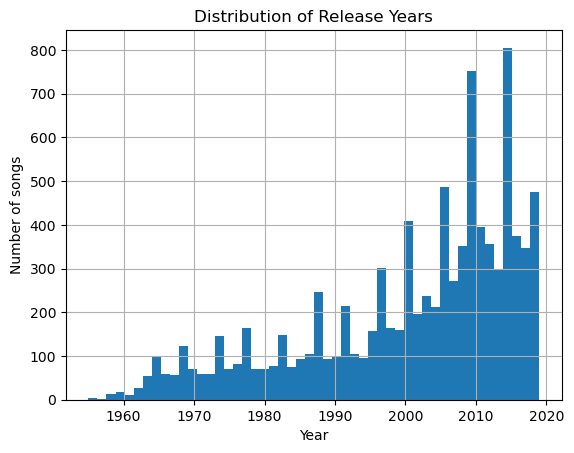

In [39]:

assert songs["year"].between(1900, 2025).all()

print(songs["year"].describe())

# Visual check
songs["year"].hist(bins=50)
plt.xlabel("Year")
plt.ylabel("Number of songs")
plt.title("Distribution of Release Years")
plt.show()


In [40]:
assert (songs["year"] % 1 == 0).all()


In [ ]:
# Global z-scores across the full analysis sample
for f in ["Danceability", "Energy", "Tempo", "duration_min"]:
    mu = songs[f].mean()
    sd = songs[f].std(ddof=0)
    songs[f"{f}_z"] = (songs[f] - mu) / sd

FEATURES_Z = ["Danceability_z", "Energy_z", "Tempo_z", "duration_min_z"]

# quick check: means ~0, stds ~1
songs[FEATURES_Z].agg(["mean", "std"]).T


,mean,std
Danceability_z,-8.517691e-17,1.000054
Energy_z,3.650439e-17,1.000054
Tempo_z,8.973996e-17,1.000054
duration_min_z,-1.946901e-16,1.000054


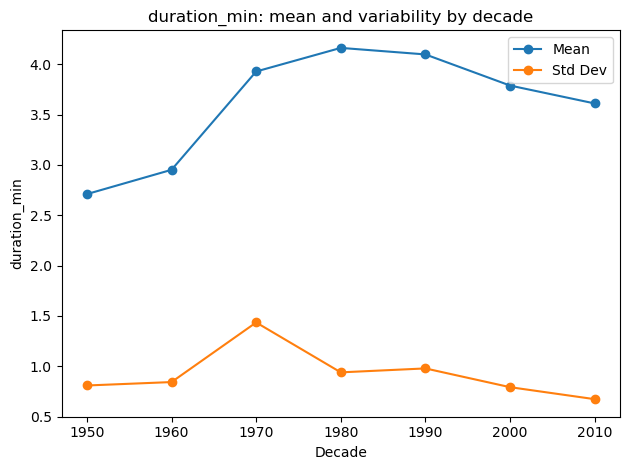

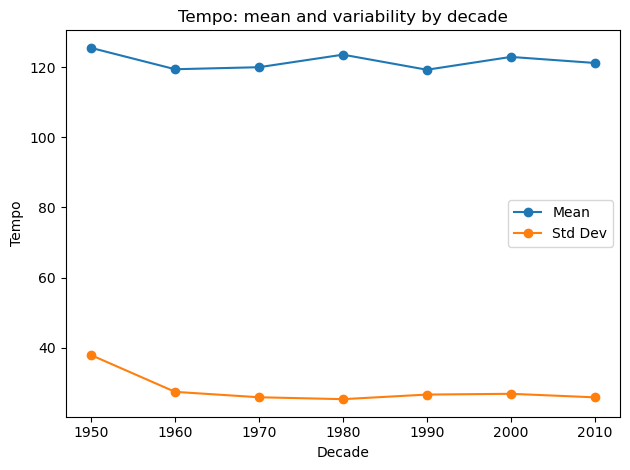

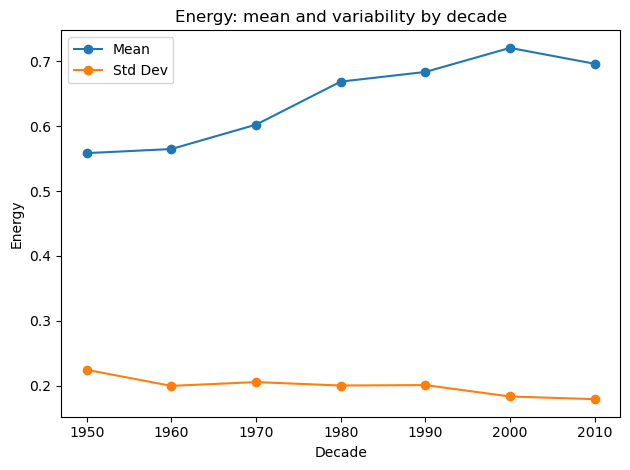

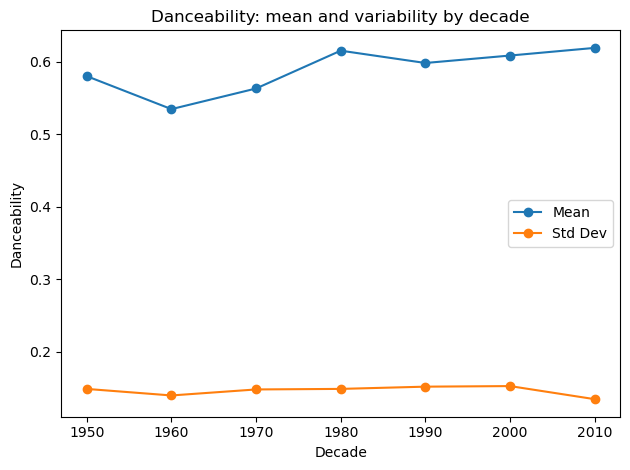

In [ ]:
# --- Figure: Feature means & SDs by decade 

decade_summary = (
    songs.groupby("decade")[["duration_min", "Tempo", "Energy", "Danceability"]]
    .agg(["mean", "std"])
    .reset_index()
)


decade_summary.columns = [
    f"{a}_{b}" if b else a
    for (a, b) in decade_summary.columns
]


for feat in ["duration_min", "Tempo", "Energy", "Danceability"]:
    tmp = decade_summary[["decade", f"{feat}_mean", f"{feat}_std"]].copy()
    tmp.columns = ["decade", "mean", "std"]

    plt.figure()
    plt.plot(tmp["decade"], tmp["mean"], marker="o", label="Mean")
    plt.plot(tmp["decade"], tmp["std"], marker="o", label="Std Dev")
    plt.xlabel("Decade")
    plt.ylabel(feat)
    plt.title(f"{feat}: mean and variability by decade")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_FIG_DIR, f"fig_feature_{feat}_mean_sd.png"), dpi=200)
    plt.show()


In [ ]:

if "duration_min" not in songs.columns:
    songs["duration_min"] = songs["Track Duration (ms)"] / 60000.0

# Ensure these columns exist (and are numeric)
FEATURES_RAW = ["Danceability", "Energy", "Tempo", "duration_min"]
for c in FEATURES_RAW:
    songs[c] = pd.to_numeric(songs[c], errors="coerce")

# Drop rows missing any feature used for z-scores
songs = songs.dropna(subset=FEATURES_RAW).copy()

# Create z-score columns
for f in FEATURES_RAW:
    mu = songs[f].mean()
    sd = songs[f].std(ddof=0)
    songs[f"{f}_z"] = (songs[f] - mu) / sd


In [44]:
songs[["Danceability_z","Energy_z","Tempo_z","duration_min_z"]].head()


,Danceability_z,Energy_z,Tempo_z,duration_min_z
2641,1.409187,0.902668,-1.171975,-1.771209
6389,1.313446,-2.997628,0.039283,-0.792454
3213,-0.327834,-0.126721,-0.998378,-1.967787
3684,1.757959,-1.037135,-0.596058,-1.161748
6956,-0.341511,-0.137066,2.407508,-1.507713


In [45]:
import re
import ast
import pandas as pd


GENRE_ORDER = [
    "Pop",
    "Rock",
    "Hip-Hop",
    "R&B/Soul",
    "Electronic",
    "Country",
    "Oldies/Standards",
    "Other",
]

MAIN_GENRES = ["Pop", "Rock", "Hip-Hop", "R&B/Soul", "Electronic", "Country"]
MERGE_LATIN_TO_OTHER = True  # keep Latin merged due to size 



def parse_genre_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()

    try:
        val = ast.literal_eval(s)
        if isinstance(val, list):
            return [str(g).strip().lower() for g in val if str(g).strip()]
    except Exception:
        pass

    # comma/semicolon separated
    parts = re.split(r"[;,]\s*", s)
    return [p.strip().lower() for p in parts if p.strip()]


PATTERNS = {
    "Country": [
        r"\bcountry\b", r"\bbluegrass\b", r"\bamericana\b", r"\bnashville\b",
        r"\bcowboy western\b", r"\bnashville sound\b"
    ],
    "Electronic": [
        r"\belectronic\b", r"\bedm\b", r"\bhouse\b", r"\btechno\b", r"\btrance\b",
        r"\bdubstep\b", r"\bdnb\b", r"\bdrum and bass\b", r"\belectronica\b",
        r"\beurodance\b", r"\bhip house\b", r"\bfrench house\b", r"\bfilter house\b",
        r"\bbig beat\b", r"\bnu skool breaks\b", r"\btrip hop\b", r"\bindietronica\b",
        r"\bambient house\b", r"\bacid house\b", r"\belectro house\b",
        r"\bprogressive house\b", r"\buk dance\b", r"\bdisco\b"
    ],
    "Hip-Hop": [
        r"\bhip hop\b", r"\bhip-hop\b", r"\brap\b", r"\btrap\b", r"\bgrime\b",
        r"\bdrill\b", r"\bmiami bass\b"
    ],
    "Pop": [
        r"\bpop\b", r"\bdance pop\b", r"\bteen pop\b", r"\bhyperpop\b",
        r"\bsynthpop\b", r"\belectropop\b", r"\buk pop\b", r"\bbubblegum pop\b",
        r"\bshimmer pop\b", r"\bpop dance\b", r"\bpost-teen pop\b"
    ],
    "Rock": [
        r"\brock\b", r"\bmodern rock\b", r"\balternative rock\b", r"\bindie rock\b",
        r"\bclassic rock\b", r"\balbum rock\b", r"\bhard rock\b", r"\bmetal\b",
        r"\bglam metal\b", r"\bpost-grunge\b", r"\bgrunge\b", r"\bpunk\b",
        r"\brockabilly\b", r"\brock and roll\b", r"\brock-and-roll\b",
        r"\bmerseybeat\b", r"\bclassic garage rock\b", r"\bbritish invasion\b",
        r"\bpermanent wave\b", r"\byacht rock\b", r"\bmellow gold\b", r"\bsoft rock\b"
    ],
    "R&B/Soul": [
        r"\br&b\b", r"\brnb\b", r"\bsoul\b", r"\bneo soul\b", r"\bnorthern soul\b",
        r"\bmotown\b", r"\burban contemporary\b", r"\bquiet storm\b",
        r"\bgospel\b", r"\bfunk\b", r"\bnew jack swing\b", r"\brhythm and blues\b",
        r"\bclassic soul\b", r"\bsouthern soul\b", r"\bbritish soul\b"
    ],
    "Oldies/Standards": [
        r"\badult standards\b", r"\bdeep adult standards\b", r"\blounge\b",
        r"\beasy listening\b", r"\bvocal jazz\b", r"\bswing\b",
        r"\btraditional pop\b", r"\bstandards\b", r"\boperatic pop\b"
    ],
    "Latin": [
        r"\breggaeton\b", r"\burbano\b", r"\burbano latino\b", r"\blatin\b",
        r"\blatin pop\b", r"\btrap latino\b", r"\bsalsa\b", r"\bbachata\b",
        r"\bmerengue\b"
    ],
}

BOOSTS = {
    "Country": [r"\bcountry\b", r"\bnashville sound\b"],
    "Electronic": [
        r"\bedm\b", r"\bhouse\b", r"\btechno\b", r"\bdnb\b", r"\bdrum and bass\b",
        r"\beurodance\b", r"\bindietronica\b", r"\bacid house\b", r"\belectro house\b"
    ],
    "Hip-Hop": [r"\bhip hop\b", r"\bhip-hop\b", r"\brap\b", r"\btrap\b", r"\bdrill\b"],
    "Pop": [r"\bdance pop\b", r"\belectropop\b", r"\buk pop\b", r"\bbubblegum pop\b", r"\bpost-teen pop\b"],
    "Rock": [
        r"\balternative rock\b", r"\bindie rock\b", r"\bmodern rock\b",
        r"\bmetal\b", r"\bhard rock\b", r"\bbritish invasion\b",
        r"\brockabilly\b", r"\brock and roll\b", r"\brock-and-roll\b"
    ],
    "R&B/Soul": [r"\br&b\b", r"\bsoul\b", r"\bneo soul\b", r"\bmotown\b", r"\burban contemporary\b"],
    "Oldies/Standards": [r"\bdeep adult standards\b", r"\badult standards\b", r"\beasy listening\b", r"\bvocal jazz\b", r"\blounge\b"],
    "Latin": [r"\breggaeton\b", r"\burbano latino\b", r"\btrap latino\b", r"\blatin pop\b"],
}


OVERRIDES = [
    (r"\brock and roll\b|\brock-and-roll\b|\brockabilly\b", "Rock"),
    (r"\bbritish invasion\b", "Rock"),
    (r"\bpop rock\b", "Rock"),
    (r"\brap metal\b|\bnu metal\b", "Rock"),

    (r"\breggaeton\b|\burbano latino\b|\btrap latino\b|\blatin pop\b|\bbachata\b|\bsalsa\b|\bmerengue\b", "Latin"),
    (r"\bpop rap\b|\bpop-rap\b|\btrap pop\b", "Pop"),
]


TIE_BREAK_MAIN = ["Rock", "R&B/Soul", "Hip-Hop", "Electronic", "Country", "Pop"]


def score_categories(g, categories):
    scores = {k: 0 for k in categories}
    for cat in categories:
        for p in PATTERNS.get(cat, []):
            if re.search(p, g):
                scores[cat] += 1
        for p in BOOSTS.get(cat, []):
            if re.search(p, g):
                scores[cat] += 2
    return scores

def pick_best(scores, tie_break):
    best = max(scores.values()) if scores else 0
    if best == 0:
        return None
    top = [k for k, v in scores.items() if v == best]
    if len(top) == 1:
        return top[0]
    for pref in tie_break:
        if pref in top:
            return pref
    return top[0]



def map_to_broad(genres):
    g = " ".join(genres)

    # (1) Overrides
    mapped = None
    for patt, label in OVERRIDES:
        if re.search(patt, g):
            mapped = label
            break

    if mapped is None:
        # (2) Score main genres
        scores_main = score_categories(g, MAIN_GENRES)

        # (3) Priority rules: R&B / Hip-Hop / Rock should beat Pop when present

        # If R&B/Soul present, demote Pop and boost R&B
        if re.search(r"\br&b\b|\brnb\b|\bsoul\b|\bneo soul\b|\bnorthern soul\b|\bmotown\b|\burban contemporary\b", g):
            scores_main["R&B/Soul"] += 3
            scores_main["Pop"] = max(scores_main["Pop"] - 2, 0)

        # If explicit Hip-Hop present, demote Pop and boost Hip-Hop
        if re.search(r"\bhip hop\b|\bhip-hop\b|\btrap\b|\bdrill\b", g):
            scores_main["Hip-Hop"] += 3
            scores_main["Pop"] = max(scores_main["Pop"] - 2, 0)

        # If explicit Rock present, demote Pop slightly and boost Rock
        if re.search(r"\brock\b|\bmodern rock\b|\balternative rock\b|\bindie rock\b|\bclassic rock\b|\bbritish invasion\b", g):
            scores_main["Rock"] += 2
            scores_main["Pop"] = max(scores_main["Pop"] - 1, 0)

        # Allow Pop to win only if Pop is present and none of the other major genres are present
        pop_present = bool(re.search(r"\bpop\b", g))
        other_major_present = any(
            re.search(p, g) for p in [
                r"\br&b\b", r"\bsoul\b",
                r"\bhip hop\b", r"\bhip-hop\b", r"\btrap\b", r"\bdrill\b",
                r"\brock\b",
                r"\bedm\b", r"\bhouse\b", r"\btechno\b", r"\belectronic\b",
                r"\bcountry\b"
            ]
        )
        if pop_present and not other_major_present:
            scores_main["Pop"] += 2

        # Prevent negatives (just in case)
        for k in scores_main:
            scores_main[k] = max(scores_main[k], 0)

        # (4) Pick winner
        mapped = pick_best(scores_main, TIE_BREAK_MAIN)

        # (5) If nothing matched, use Oldies/Standards only if standards-like terms exist
        if mapped is None:
            standards_like = bool(re.search(
                r"\bdeep adult standards\b|\badult standards\b|\beasy listening\b|\bvocal jazz\b|\btraditional pop\b|\boperatic pop\b|\bswing\b|\blounge\b",
                g
            ))
            mapped = "Oldies/Standards" if standards_like else "Other"

    # (6) Latin handling
    if mapped == "Latin" and MERGE_LATIN_TO_OTHER:
        mapped = "Other"

    # (7) Safety
    if mapped not in GENRE_ORDER:
        mapped = "Other"

    return mapped



songs_genre = songs.dropna(subset=["Artist Genres"]).copy()
songs_genre["genres_list"] = songs_genre["Artist Genres"].apply(parse_genre_list)
songs_genre["broad_genre"] = songs_genre["genres_list"].apply(map_to_broad)

songs_genre = songs_genre[songs_genre["broad_genre"].isin(GENRE_ORDER)].copy()
songs_genre["broad_genre"] = pd.Categorical(
    songs_genre["broad_genre"], categories=GENRE_ORDER, ordered=True
)


print("songs_genre shape:", songs_genre.shape)
print("\nCounts:\n", songs_genre["broad_genre"].value_counts())

songs_genre["n_tags"] = songs_genre["genres_list"].apply(len)
print("\nTag count summary:\n", songs_genre["n_tags"].describe())

for cat in GENRE_ORDER:
    ex = songs_genre.loc[songs_genre["broad_genre"] == cat, "Artist Genres"].head(5).tolist()
    print(f"\n{cat} examples:")
    for e in ex:
        print("  ", e)



songs_genre shape: (8853, 44)

Counts:
 broad_genre
Rock                3829
Pop                 2517
R&B/Soul             843
Electronic           635
Other                516
Hip-Hop              279
Country              155
Oldies/Standards      79
Name: count, dtype: int64

Tag count summary:
 count    8853.000000
mean        3.968485
std         2.795529
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        33.000000
Name: n_tags, dtype: float64

Pop examples:
   brill building pop,bubblegum pop,classic girl group
   brill building pop,bubblegum pop,classic girl group
   brill building pop,bubblegum pop,classic girl group
   brill building pop,bubblegum pop,classic girl group
   brill building pop

Rock examples:
   rock-and-roll,rockabilly
   rock-and-roll,rockabilly
   arkansas country,outlaw country,rock
   blues,rock-and-roll,rockabilly,soul
   rock-and-roll,rockabilly

Hip-Hop examples:
   bronx hip hop,old school hip hop
   alternativ

In [46]:
# --- Build decade-genre dispersion table (cell) ---

Z_COLS = ["Danceability_z", "Energy_z", "Tempo_z", "duration_min_z"]
missing_z = [c for c in Z_COLS if c not in songs.columns]
if missing_z:
    raise ValueError(f"Missing z-score columns on songs: {missing_z}. Run the z-score block first.")

# If songs_genre doesn't already have z cols, merge them in
missing_z_g = [c for c in Z_COLS if c not in songs_genre.columns]
if missing_z_g:
    if "Track URI" not in songs_genre.columns or "Track URI" not in songs.columns:
        raise ValueError("Need 'Track URI' in BOTH songs_genre and songs to merge z-scores.")
    songs_genre = songs_genre.merge(
        songs[["Track URI"] + Z_COLS],
        on="Track URI",
        how="left",
        validate="m:1",
    )

cell = (
    songs_genre
    .groupby(["decade", "broad_genre"], observed=True)
    .agg(
        n_songs=("decade", "size"),
        Danceability_std=("Danceability_z", "std"),
        Energy_std=("Energy_z", "std"),
        Tempo_std=("Tempo_z", "std"),
        duration_min_std=("duration_min_z", "std"),
    )
    .reset_index()
)

cell = cell[cell["n_songs"] >= MIN_N_CELL].copy()

STD_COLS = ["Danceability_std", "Energy_std", "Tempo_std", "duration_min_std"]
cell["dispersion"] = cell[STD_COLS].mean(axis=1)
cell["decade_centered"] = cell["decade"] - 1980

cell.head()




,decade,broad_genre,n_songs,Danceability_std,Energy_std,Tempo_std,duration_min_std,dispersion,decade_centered
0,1950,Rock,21,0.967071,1.059166,1.424632,0.533618,0.996122,-30
4,1960,Pop,25,1.028326,0.898517,1.441258,0.744373,1.028119,-20
5,1960,Rock,296,0.858255,1.046368,1.000647,0.966757,0.968007,-20
6,1960,R&B/Soul,71,1.160713,0.927692,1.017224,0.698479,0.951027,-20
8,1960,Country,14,0.644370,1.263176,1.027697,0.639399,0.893661,-20


In [47]:
songs["Track URI"].is_unique


True

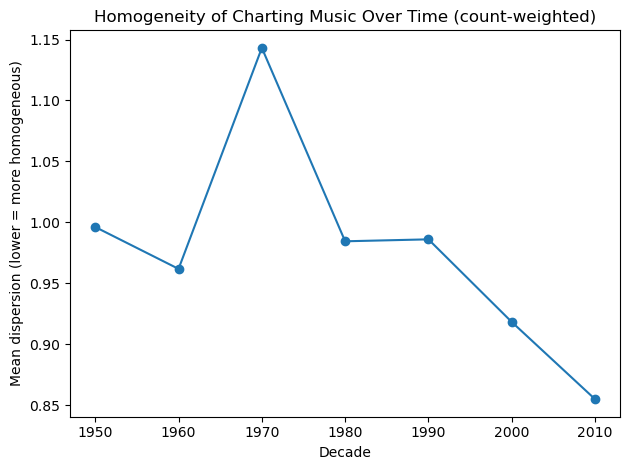

,decade,dispersion_count_weight
0,1950,0.996122
1,1960,0.961770
2,1970,1.143145
3,1980,0.984415
4,1990,0.986012
5,2000,0.918215
6,2010,0.854846


In [48]:
# --- Figure: Homogeneity over time (count-weighted)

cell_plot = cell.copy()
cell_plot["w_in_decade"] = cell_plot["n_songs"] / cell_plot.groupby("decade")["n_songs"].transform("sum")

agg_count = (
    cell_plot.groupby("decade", as_index=False)
    .apply(lambda g: np.sum(g["w_in_decade"] * g["dispersion"]), include_groups=False)
    .rename(columns={None: "dispersion_count_weight"})
    .sort_values("decade")
)

plt.figure()
plt.plot(agg_count["decade"], agg_count["dispersion_count_weight"], marker="o")
plt.xlabel("Decade")
plt.ylabel("Mean dispersion (lower = more homogeneous)")
plt.title("Homogeneity of Charting Music Over Time (count-weighted)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_homogeneity_over_time_count_weight.png"), dpi=200)
plt.show()

agg_count


In [49]:
# 1) Weights should sum to 1 within each decade (up to floating error)
cell_plot.groupby("decade")["w_in_decade"].sum()


decade
1950    1.0
1960    1.0
1970    1.0
1980    1.0
1990    1.0
2000    1.0
2010    1.0
Name: w_in_decade, dtype: float64

In [50]:
cell_plot["dispersion"].isna().sum()

0

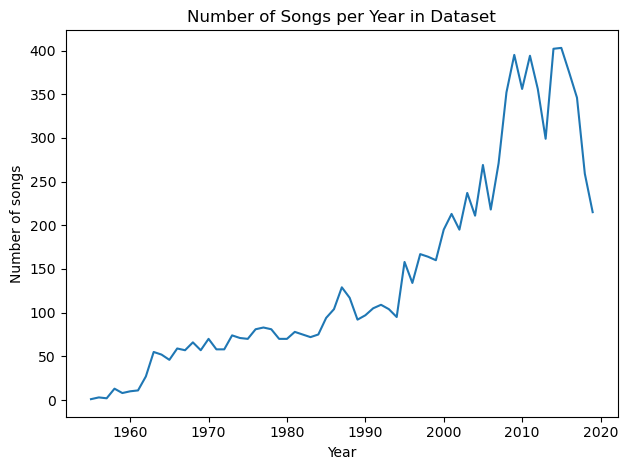

In [51]:
# --- Figure: Number of songs per year

songs_per_year = songs.groupby("year", as_index=False).size().rename(columns={"size": "n_songs"}).sort_values("year")

plt.figure()
plt.plot(songs_per_year["year"], songs_per_year["n_songs"])
plt.xlabel("Year")
plt.ylabel("Number of songs")
plt.title("Number of Songs per Year in Dataset")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_songs_per_year.png"), dpi=200)
plt.show()


/var/folders/8w/tsh0nsxs46dfwqy988fbrf8c0000gn/T/ipykernel_64195/1082564663.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  songs_genre.groupby(["decade", "broad_genre"], as_index=False)


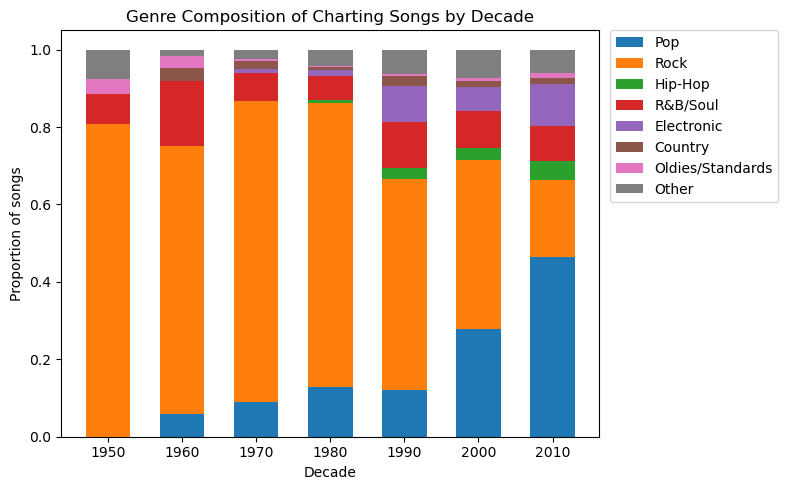

In [52]:
# --- Figure: Genre composition by decade 

genre_comp = (
    songs_genre.groupby(["decade", "broad_genre"], as_index=False)
    .size()
    .rename(columns={"size": "n"})
)
genre_comp["prop"] = genre_comp["n"] / genre_comp.groupby("decade")["n"].transform("sum")

comp_pivot = genre_comp.pivot(index="decade", columns="broad_genre", values="prop").fillna(0.0)
comp_pivot = comp_pivot[GENRE_ORDER]

plt.figure(figsize=(8, 5))

bottom = np.zeros(len(comp_pivot))
x = comp_pivot.index.values
bar_width = 6

for g in GENRE_ORDER:
    plt.bar(
        x,
        comp_pivot[g].values,
        bottom=bottom,
        width=bar_width,
        label=g
    )
    bottom += comp_pivot[g].values

plt.xlabel("Decade")
plt.ylabel("Proportion of songs")
plt.title("Genre Composition of Charting Songs by Decade")

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=True
)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_FIG_DIR, "fig_genre_composition_by_decade.png"),
    dpi=200,
    bbox_inches="tight"  
)
plt.show()


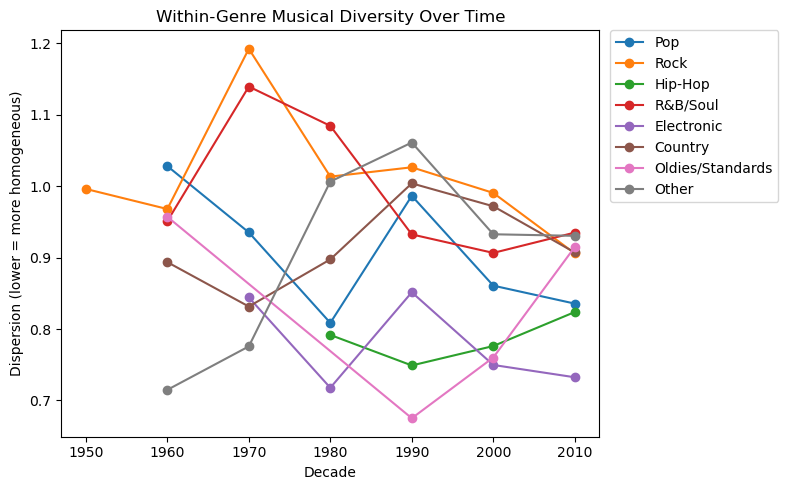

In [53]:
# --- Figure: Within-genre homogeneity trends (dispersion by decade within each genre)

plt.figure(figsize=(8, 5))

for g in GENRE_ORDER:
    tmp = cell[cell["broad_genre"] == g].sort_values("decade")
    if len(tmp) == 0:
        continue
    plt.plot(tmp["decade"], tmp["dispersion"], marker="o", label=g)

plt.xlabel("Decade")
plt.ylabel("Dispersion (lower = more homogeneous)")
plt.title("Within-Genre Musical Diversity Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_within_genre_trends.png"), dpi=200, bbox_inches="tight")
plt.show()


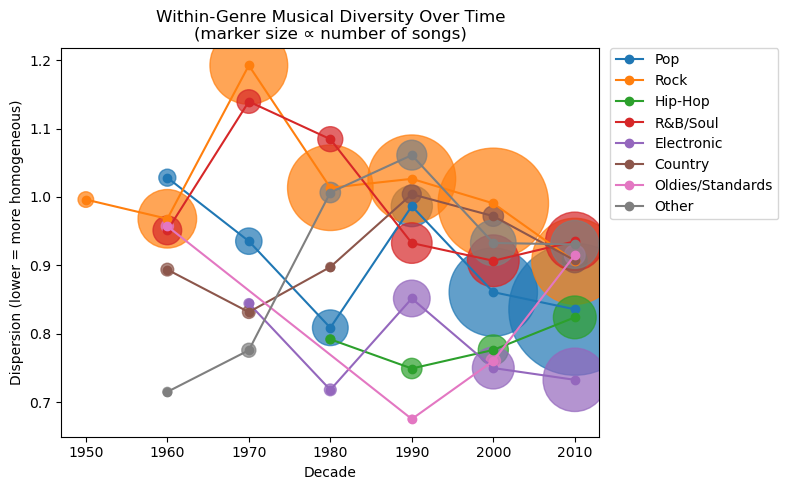

In [54]:


plt.figure(figsize=(8, 5))


SIZE_SCALE = 6
MIN_SIZE = 20

for g in GENRE_ORDER:
    tmp = cell[cell["broad_genre"] == g].sort_values("decade")
    if len(tmp) == 0:
        continue

    sizes = np.clip(tmp["n_songs"] * SIZE_SCALE, MIN_SIZE, None)

    plt.plot(
        tmp["decade"],
        tmp["dispersion"],
        marker="o",
        label=g,
        linewidth=1.5
    )

    plt.scatter(
        tmp["decade"],
        tmp["dispersion"],
        s=sizes,
        alpha=0.7
    )

plt.xlabel("Decade")
plt.ylabel("Dispersion (lower = more homogeneous)")
plt.title("Within-Genre Musical Diversity Over Time\n(marker size ∝ number of songs)")

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=True
)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_FIG_DIR, "fig_within_genre_trends_size_weighted.png"),
    dpi=200,
    bbox_inches="tight"
)
plt.show()


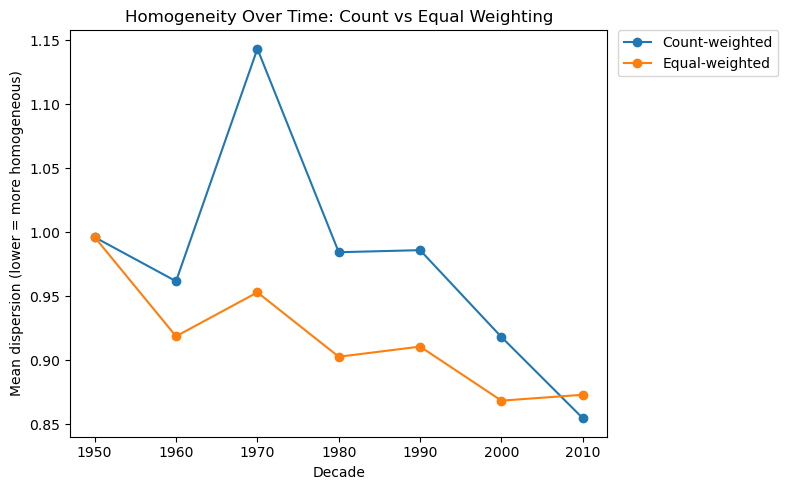

,decade,count_weight,equal_weight
0,1950,0.996122,0.996122
1,1960,0.961770,0.918808
2,1970,1.143145,0.953081
3,1980,0.984415,0.902850
4,1990,0.986012,0.910766
5,2000,0.918215,0.868578
6,2010,0.854846,0.873177


In [55]:
# --- Figure: Equal-weight vs count-weight homogeneity over time

tmp = cell.copy()
tmp["w_in_decade"] = tmp["n_songs"] / tmp.groupby("decade")["n_songs"].transform("sum")

count_weight = (
    tmp.groupby("decade", as_index=False)
    .apply(lambda g: np.sum(g["w_in_decade"] * g["dispersion"]), include_groups=False)
    .rename(columns={None: "count_weight"})
)

equal_weight = (
    tmp.groupby("decade", as_index=False)["dispersion"]
    .mean()
    .rename(columns={"dispersion": "equal_weight"})
)

comp = count_weight.merge(equal_weight, on="decade").sort_values("decade")

plt.figure(figsize=(8, 5))
plt.plot(comp["decade"], comp["count_weight"], marker="o", label="Count-weighted")
plt.plot(comp["decade"], comp["equal_weight"], marker="o", label="Equal-weighted")
plt.xlabel("Decade")
plt.ylabel("Mean dispersion (lower = more homogeneous)")
plt.title("Homogeneity Over Time: Count vs Equal Weighting")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_equal_vs_count_weight.png"), dpi=200, bbox_inches="tight")
plt.show()

comp


/var/folders/8w/tsh0nsxs46dfwqy988fbrf8c0000gn/T/ipykernel_64195/3112083464.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  songs_genre.groupby(["decade", "broad_genre"], as_index=False)


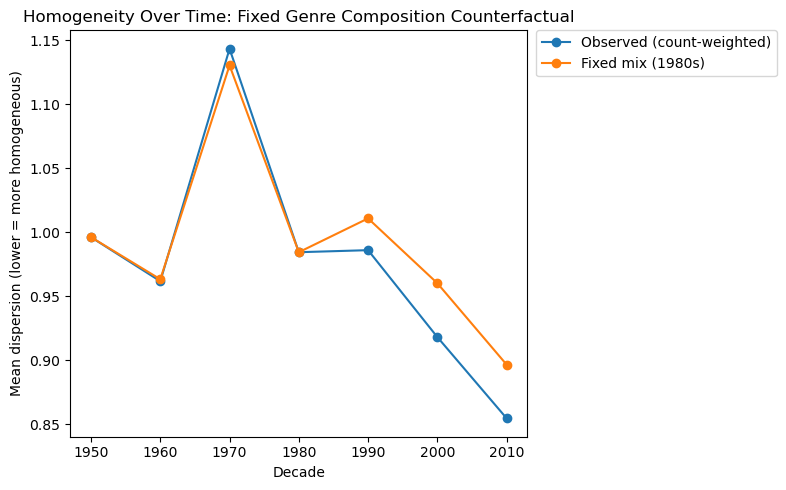

,decade,observed,fixed_mix
0,1950,0.996122,0.996122
1,1960,0.961770,0.963293
2,1970,1.143145,1.130212
3,1980,0.984415,0.984415
4,1990,0.986012,1.010793
5,2000,0.918215,0.960234
6,2010,0.854846,0.896720


In [56]:
# --- Figure: Observed vs fixed-genre-composition counterfactual

BASE_DECADE = 1980

# observed count-weighted
tmp = cell.copy()
tmp["w_in_decade"] = tmp["n_songs"] / tmp.groupby("decade")["n_songs"].transform("sum")

observed = (
    tmp.groupby("decade", as_index=False)
    .apply(lambda g: np.sum(g["w_in_decade"] * g["dispersion"]), include_groups=False)
    .rename(columns={None: "observed"})
)

# build base genre mix using songs_genre
genre_mix = (
    songs_genre.groupby(["decade", "broad_genre"], as_index=False)
    .size()
    .rename(columns={"size": "n"})
)
genre_mix["prop"] = genre_mix["n"] / genre_mix.groupby("decade")["n"].transform("sum")

base_mix = (
    genre_mix[genre_mix["decade"] == BASE_DECADE]
    .set_index("broad_genre")["prop"]
    .reindex(GENRE_ORDER)
    .fillna(0.0)
)

# apply fixed mix to each decade’s within-genre dispersions
fixed_rows = []
for d, gdf in cell.groupby("decade"):
    disp = gdf.set_index("broad_genre")["dispersion"].reindex(GENRE_ORDER)
    ok = disp.notna()
    w = base_mix[ok]
    if w.sum() == 0:
        val = np.nan
    else:
        w = w / w.sum()
        val = float(np.sum(w.values * disp[ok].values))
    fixed_rows.append((d, val))

fixed = pd.DataFrame(fixed_rows, columns=["decade", "fixed_mix"])

plot_df = observed.merge(fixed, on="decade", how="left").sort_values("decade")

plt.figure(figsize=(8, 5))
plt.plot(plot_df["decade"], plot_df["observed"], marker="o", label="Observed (count-weighted)")
plt.plot(plot_df["decade"], plot_df["fixed_mix"], marker="o", label=f"Fixed mix ({BASE_DECADE}s)")
plt.xlabel("Decade")
plt.ylabel("Mean dispersion (lower = more homogeneous)")
plt.title("Homogeneity Over Time: Fixed Genre Composition Counterfactual")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_fixed_composition_counterfactual.png"), dpi=200, bbox_inches="tight")
plt.show()

plot_df


/var/folders/8w/tsh0nsxs46dfwqy988fbrf8c0000gn/T/ipykernel_64195/3030557533.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  songs_genre.groupby(["decade", "broad_genre"], as_index=False)


,decade,observed,fixed_1970,fixed_1980,fixed_1990
0,1950,0.996122,0.996122,0.996122,0.996122
1,1960,0.961770,0.964125,0.963293,0.953484
2,1970,1.143145,1.143145,1.130212,1.082972
3,1980,0.984415,0.993970,0.984415,0.958802
4,1990,0.986012,1.013423,1.010793,0.986012
5,2000,0.918215,0.967529,0.960234,0.930859
6,2010,0.854846,0.900294,0.896720,0.883546


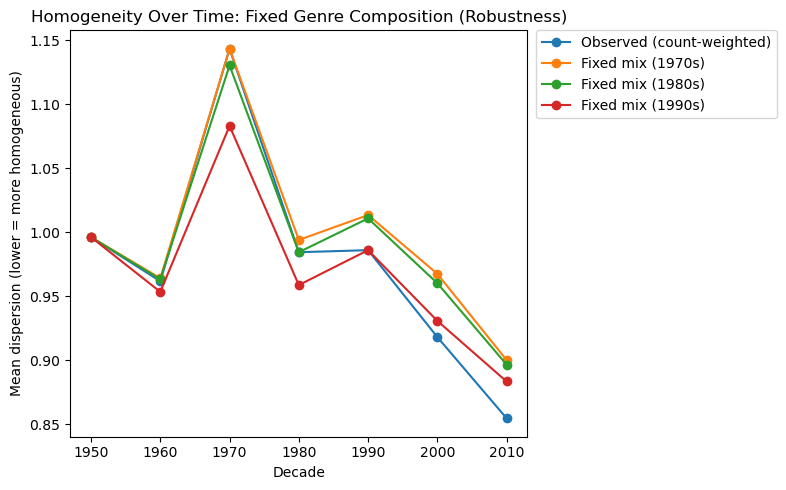

In [57]:
# --- Robustness: alternate base decades for fixed-genre-composition counterfactual ---

BASE_DECADES = [1970, 1980, 1990]  # change/add as you like

# 1) Observed (count-weighted) homogeneity by decade (same for all base decades)
tmp = cell.copy()
tmp["w_in_decade"] = tmp["n_songs"] / tmp.groupby("decade")["n_songs"].transform("sum")

observed = (
    tmp.groupby("decade", as_index=False)
      .apply(lambda g: np.sum(g["w_in_decade"] * g["dispersion"]), include_groups=False)
      .rename(columns={None: "observed"})
)

# 2) Genre mix table (shares by decade) from songs_genre
genre_mix = (
    songs_genre.groupby(["decade", "broad_genre"], as_index=False)
      .size()
      .rename(columns={"size": "n"})
)
genre_mix["prop"] = genre_mix["n"] / genre_mix.groupby("decade")["n"].transform("sum")

# 3) Compute fixed-mix counterfactual line for each BASE_DECADE
fixed_lines = []

for BASE_DECADE in BASE_DECADES:
    base_mix = (
        genre_mix.loc[genre_mix["decade"] == BASE_DECADE, ["broad_genre", "prop"]]
          .set_index("broad_genre")["prop"]
          .reindex(GENRE_ORDER)
          .fillna(0.0)
    )

    fixed_rows = []
    for d, gdf in cell.groupby("decade"):
        disp = gdf.set_index("broad_genre")["dispersion"].reindex(GENRE_ORDER)
        ok = disp.notna()

        w = base_mix[ok]
        if w.sum() == 0:
            val = np.nan
        else:
            w = w / w.sum()  # renormalize if some genres don't exist in this decade
            val = float(np.sum(w.values * disp[ok].values))

        fixed_rows.append((d, val))

    fixed = pd.DataFrame(fixed_rows, columns=["decade", f"fixed_{BASE_DECADE}"])
    fixed_lines.append(fixed)

# 4) Merge into one plotting DF
plot_df = observed.copy()
for fixed in fixed_lines:
    plot_df = plot_df.merge(fixed, on="decade", how="left")

plot_df = plot_df.sort_values("decade")
display(plot_df)

# 5) Plot: observed vs each fixed-mix base decade
plt.figure(figsize=(8, 5))
plt.plot(plot_df["decade"], plot_df["observed"], marker="o", label="Observed (count-weighted)")

for BASE_DECADE in BASE_DECADES:
    col = f"fixed_{BASE_DECADE}"
    plt.plot(plot_df["decade"], plot_df[col], marker="o", label=f"Fixed mix ({BASE_DECADE}s)")

plt.xlabel("Decade")
plt.ylabel("Mean dispersion (lower = more homogeneous)")
plt.title("Homogeneity Over Time: Fixed Genre Composition (Robustness)")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
plt.tight_layout()

plt.savefig(
    os.path.join(OUT_FIG_DIR, "fig_fixed_composition_counterfactual_robustness.png"),
    dpi=200,
    bbox_inches="tight",
)
plt.show()


In [58]:
# --- Figure/Table: Regression of dispersion on decade + genre controls (cell-level)

# Make sure decade_centered exists (you created it in cell-building block, but safe)
if "decade_centered" not in cell.columns:
    cell = cell.copy()
    cell["decade_centered"] = cell["decade"] - 1980

# Weighted least squares using n_songs as weights
m1 = smf.wls("dispersion ~ decade_centered + C(broad_genre)", data=cell, weights=cell["n_songs"]).fit(cov_type="HC3")
print(m1.summary())

with open(os.path.join(OUT_TAB_DIR, "reg_dispersion_wls_genre_controls.txt"), "w") as f:
    f.write(m1.summary().as_text())


                            WLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.745
Model:                            WLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     12.37
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           3.33e-08
Time:                        11:07:40   Log-Likelihood:                 42.942
No. Observations:                  44   AIC:                            -67.88
Df Residuals:                      35   BIC:                            -51.83
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [59]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Safety: ensure centered decade exists
if "decade_centered" not in cell.columns:
    cell = cell.copy()
    cell["decade_centered"] = cell["decade"] - 1980


In [60]:
m_wls_cluster_decade = smf.wls(
    "dispersion ~ decade_centered + C(broad_genre)",
    data=cell,
    weights=cell["n_songs"]
).fit(cov_type="cluster", cov_kwds={"groups": cell["decade"]})

print(m_wls_cluster_decade.summary())


                            WLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.745
Model:                            WLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     945.9
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.18e-08
Time:                        11:07:40   Log-Likelihood:                 42.942
No. Observations:                  44   AIC:                            -67.88
Df Residuals:                      35   BIC:                            -51.83
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [61]:
m_ols_equal = smf.ols(
    "dispersion ~ decade_centered + C(broad_genre)",
    data=cell
).fit(cov_type="HC3")

m_wls_count = smf.wls(
    "dispersion ~ decade_centered + C(broad_genre)",
    data=cell,
    weights=cell["n_songs"]
).fit(cov_type="HC3")

print("Equal-weighted OLS:")
print(m_ols_equal.summary())

print("\nCount-weighted WLS:")
print(m_wls_count.summary())


Equal-weighted OLS:
                            OLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     6.808
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           2.28e-05
Time:                        11:07:40   Log-Likelihood:                 46.806
No. Observations:                  44   AIC:                            -75.61
Df Residuals:                      35   BIC:                            -59.55
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [62]:
def coef_row(model, name="decade_centered"):
    return pd.Series({
        "coef": model.params.get(name, np.nan),
        "se": model.bse.get(name, np.nan),
        "p": model.pvalues.get(name, np.nan),
        "n": int(model.nobs)
    })

compare = pd.DataFrame({
    "OLS_equal": coef_row(m_ols_equal),
    "WLS_count": coef_row(m_wls_count),
    "WLS_cluster_decade": coef_row(m_wls_cluster_decade),
}).T

compare


,coef,se,p,n
OLS_equal,-0.000530,0.000950,0.577167,44.0
WLS_count,-0.002698,0.001559,0.083502,44.0
WLS_cluster_decade,-0.002698,0.001470,0.066546,44.0


In [63]:
m_wls_decadeFE = smf.wls(
    "dispersion ~ C(decade) + C(broad_genre)",
    data=cell,
    weights=cell["n_songs"]
).fit(cov_type="HC3")

print(m_wls_decadeFE.summary())


                            WLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.876
Model:                            WLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     21.29
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.24e-11
Time:                        11:07:40   Log-Likelihood:                 58.878
No. Observations:                  44   AIC:                            -89.76
Df Residuals:                      30   BIC:                            -64.78
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

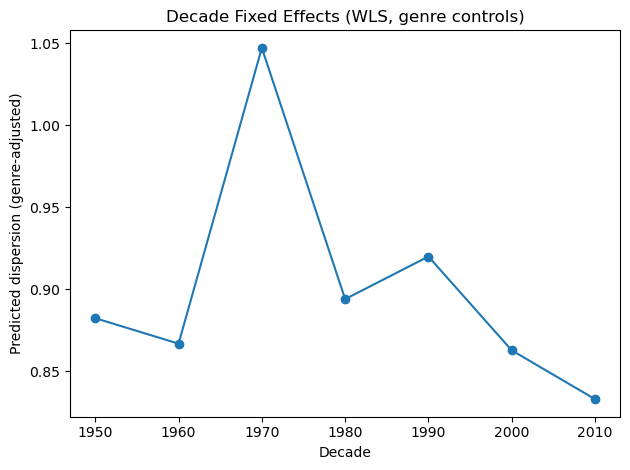

In [64]:
import matplotlib.pyplot as plt

base_decade = 1980  
params = m_wls_decadeFE.params


decades = sorted(cell["decade"].unique())
effects = []
ses = []

for d in decades:
    term = f"C(decade)[T.{d}]"

    eff = params["Intercept"] + (params[term] if term in params.index else 0.0)
    effects.append(eff)

  
    ses.append(np.nan)

plt.figure()
plt.plot(decades, effects, marker="o")
plt.xlabel("Decade")
plt.ylabel("Predicted dispersion (genre-adjusted)")
plt.title("Decade Fixed Effects (WLS, genre controls)")
plt.tight_layout()
plt.show()


In [65]:
m_wls_interaction = smf.wls(
    "dispersion ~ decade_centered * C(broad_genre)",
    data=cell,
    weights=cell["n_songs"]
).fit(cov_type="HC3")

print(m_wls_interaction.summary())


                            WLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.766
Model:                            WLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     12.06
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.72e-08
Time:                        11:07:40   Log-Likelihood:                 44.839
No. Observations:                  44   AIC:                            -57.68
Df Residuals:                      28   BIC:                            -29.13
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [66]:
genres = sorted(cell["broad_genre"].unique())
base = genres[0]  

base_slope = m_wls_interaction.params["decade_centered"]
rows = []

for g in genres:
    if g == base:
        slope = base_slope
    else:
        term = f"decade_centered:C(broad_genre)[T.{g}]"
        slope = base_slope + (m_wls_interaction.params[term] if term in m_wls_interaction.params.index else 0.0)
    rows.append((g, slope))

pd.DataFrame(rows, columns=["genre", "implied_decade_slope"]).sort_values("implied_decade_slope")


,genre,implied_decade_slope
1,Electronic,-0.003975
7,Rock,-0.003298
0,Country,-0.002528
5,Pop,-0.002528
6,R&B/Soul,-0.002162
3,Oldies/Standards,-0.000793
4,Other,-0.000156
2,Hip-Hop,0.003168


In [67]:
m_wls_sqrt = smf.wls(
    "dispersion ~ decade_centered + C(broad_genre)",
    data=cell,
    weights=np.sqrt(cell["n_songs"])
).fit(cov_type="HC3")

print(m_wls_sqrt.summary())


                            WLS Regression Results                            
Dep. Variable:             dispersion   R-squared:                       0.615
Model:                            WLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     6.909
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.97e-05
Time:                        11:07:40   Log-Likelihood:                 48.968
No. Observations:                  44   AIC:                            -79.94
Df Residuals:                      35   BIC:                            -63.88
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

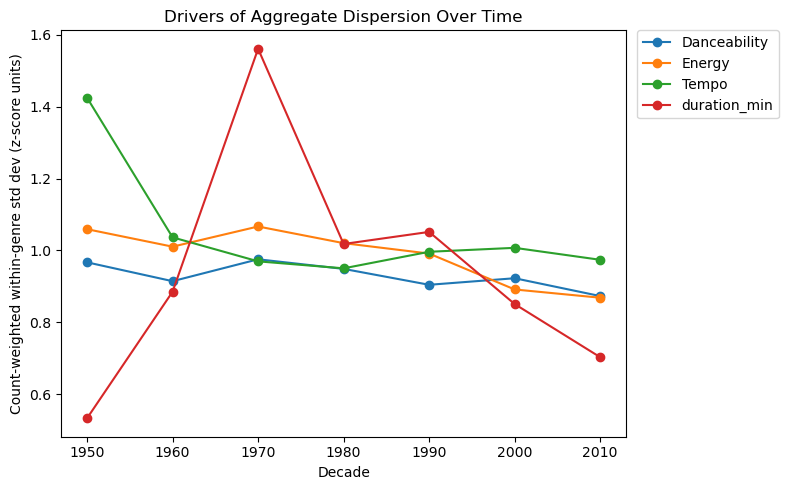

,decade,Danceability_std,Energy_std,Tempo_std,duration_min_std
0,1950,0.967071,1.059166,1.424632,0.533618
1,1960,0.914637,1.010588,1.036492,0.885365
2,1970,0.975493,1.066682,0.969775,1.560630
3,1980,0.948850,1.020382,0.950373,1.018055
4,1990,0.904621,0.991408,0.996391,1.051629
5,2000,0.922847,0.891619,1.007363,0.851031
6,2010,0.873276,0.868677,0.974092,0.703337


In [68]:
# --- Figure: Decompose dispersion into its feature components over time (count-weighted)

tmp = cell.copy()
tmp["w_in_decade"] = tmp["n_songs"] / tmp.groupby("decade")["n_songs"].transform("sum")

components = []
for feat in ["Danceability_std", "Energy_std", "Tempo_std", "duration_min_std"]:
    comp = (
        tmp.groupby("decade", as_index=False)
        .apply(lambda g: np.sum(g["w_in_decade"] * g[feat]), include_groups=False)
        .rename(columns={None: feat})
    )
    components.append(comp.set_index("decade")[feat])

comp_df = pd.concat(components, axis=1).reset_index().rename(columns={"index": "decade"}).sort_values("decade")

plt.figure(figsize=(8, 5))
for feat in ["Danceability_std", "Energy_std", "Tempo_std", "duration_min_std"]:
    plt.plot(comp_df["decade"], comp_df[feat], marker="o", label=feat.replace("_std", ""))

plt.xlabel("Decade")
plt.ylabel("Count-weighted within-genre std dev (z-score units)")
plt.title("Drivers of Aggregate Dispersion Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_dispersion_decomposition_components.png"), dpi=200, bbox_inches="tight")
plt.show()

comp_df


/var/folders/8w/tsh0nsxs46dfwqy988fbrf8c0000gn/T/ipykernel_64195/4210298491.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["decade", "broad_genre"])


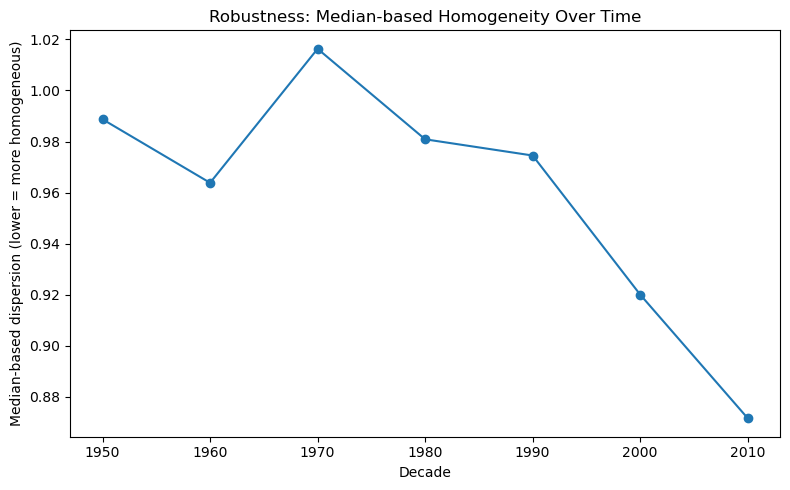

In [69]:
# --- Optional robustness: median-based dispersion index (genre-decade)

cell_med = (
    songs_genre
    .groupby(["decade", "broad_genre"])
    .agg(
        n_songs=("Track URI", "size"),
        Danceability_std=("Danceability_z", lambda x: np.nanstd(x, ddof=0)),
        Energy_std=("Energy_z", lambda x: np.nanstd(x, ddof=0)),
        Tempo_std=("Tempo_z", lambda x: np.nanstd(x, ddof=0)),
        duration_min_std=("duration_min_z", lambda x: np.nanstd(x, ddof=0)),
    )
    .reset_index()
)

cell_med = cell_med[cell_med["n_songs"] >= MIN_N_CELL].copy()
cell_med["dispersion"] = cell_med[STD_COLS].median(axis=1)

cell_med["w_in_decade"] = cell_med["n_songs"] / cell_med.groupby("decade")["n_songs"].transform("sum")

agg_med = (
    cell_med.groupby("decade", as_index=False)
    .apply(lambda g: np.sum(g["w_in_decade"] * g["dispersion"]), include_groups=False)
    .rename(columns={None: "dispersion_median_index"})
    .sort_values("decade")
)

plt.figure(figsize=(8, 5))
plt.plot(agg_med["decade"], agg_med["dispersion_median_index"], marker="o")
plt.xlabel("Decade")
plt.ylabel("Median-based dispersion (lower = more homogeneous)")
plt.title("Robustness: Median-based Homogeneity Over Time")
plt.tight_layout()
plt.savefig(os.path.join(OUT_FIG_DIR, "fig_homogeneity_median_based.png"), dpi=200)
plt.show()


Saved figure -> outputs/figures/fig_homogeneity_no_duration_count_weight.png


/var/folders/8w/tsh0nsxs46dfwqy988fbrf8c0000gn/T/ipykernel_64195/73035045.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = songs_nd.groupby(["decade", "broad_genre"])


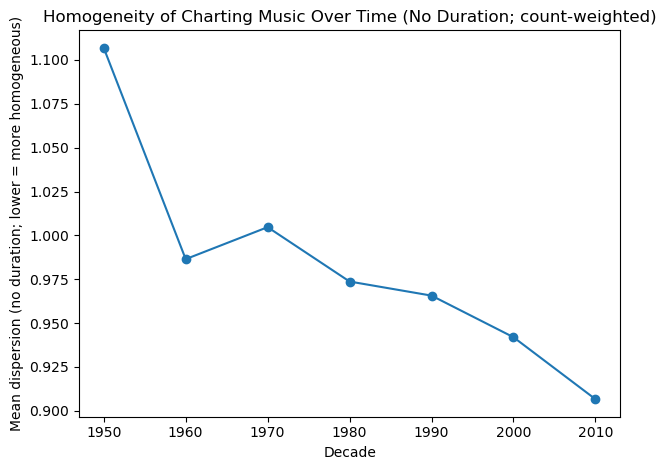

                              WLS Regression Results                              
Dep. Variable:     dispersion_no_duration   R-squared:                       0.821
Model:                                WLS   Adj. R-squared:                  0.785
Method:                     Least Squares   F-statistic:                     12.27
Date:                    Thu, 15 Jan 2026   Prob (F-statistic):           1.43e-08
Time:                            11:07:41   Log-Likelihood:                 58.715
No. Observations:                      48   AIC:                            -99.43
Df Residuals:                          39   BIC:                            -82.59
Df Model:                               8                                         
Covariance Type:                      HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

In [70]:

# Robustness check: re-run homogeneity WITHOUT duration_min


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import os

# ---- Safety checks ----
required_cols = {"decade", "broad_genre", "Danceability", "Energy", "Tempo"}
missing = sorted(list(required_cols - set(songs_genre.columns)))
if missing:
    raise ValueError(
        f"`songs_genre` is missing required columns: {missing}. "
        "Run the genre mapping cell that creates `songs_genre` first."
    )

songs_nd = songs_genre.copy()


FEATS_NO_DUR = ["Danceability", "Energy", "Tempo"]
Z_COLS_NO_DUR = [f"{c}_z" for c in FEATS_NO_DUR]

for c, zc in zip(FEATS_NO_DUR, Z_COLS_NO_DUR):
    mu = songs_nd[c].mean()
    sd = songs_nd[c].std(ddof=0)
    songs_nd[zc] = (songs_nd[c] - mu) / sd


g = songs_nd.groupby(["decade", "broad_genre"])

# counts
cell_nd = g.size().reset_index(name="n_songs")

# std devs for each standardized feature
for c, zc in zip(FEATS_NO_DUR, Z_COLS_NO_DUR):
    tmp = g[zc].std().reset_index(name=f"{c}_std")
    cell_nd = cell_nd.merge(tmp, on=["decade", "broad_genre"], how="left")

STD_COLS_NO_DUR = [f"{c}_std" for c in FEATS_NO_DUR]
cell_nd["dispersion_no_duration"] = cell_nd[STD_COLS_NO_DUR].mean(axis=1)


cell_nd["w_in_decade"] = cell_nd["n_songs"] / cell_nd.groupby("decade")["n_songs"].transform("sum")

agg_nd = (
    cell_nd.assign(wdisp=cell_nd["w_in_decade"] * cell_nd["dispersion_no_duration"])
    .groupby("decade", as_index=False)["wdisp"]
    .sum()
    .rename(columns={"wdisp": "dispersion_no_duration_count_weight"})
)

# Plot 
plt.figure()
plt.plot(agg_nd["decade"], agg_nd["dispersion_no_duration_count_weight"], marker="o")
plt.xlabel("Decade")
plt.ylabel("Mean dispersion (no duration; lower = more homogeneous)")
plt.title("Homogeneity of Charting Music Over Time (No Duration; count-weighted)")
plt.tight_layout()

try:
    os.makedirs(OUT_FIG_DIR, exist_ok=True)
    outpath = os.path.join(OUT_FIG_DIR, "fig_homogeneity_no_duration_count_weight.png")
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    print(f"Saved figure -> {outpath}")
except NameError:
    print("OUT_FIG_DIR not defined; figure not saved (but displayed in notebook).")

plt.show()

#  Regression: same WLS spec but using dispersion_no_duration 
cell_nd["decade_centered"] = cell_nd["decade"] - 1980

m_nd = smf.wls(
    "dispersion_no_duration ~ decade_centered + C(broad_genre)",
    data=cell_nd,
    weights=cell_nd["n_songs"]
).fit(cov_type="HC3")

print(m_nd.summary())


try:
    os.makedirs(OUT_TAB_DIR, exist_ok=True)
    tabpath = os.path.join(OUT_TAB_DIR, "cell_no_duration.csv")
    cell_nd.to_csv(tabpath, index=False)
    print(f"Saved table -> {tabpath}")
except NameError:
    print("OUT_TAB_DIR not defined; table not saved.")


Saved figure -> outputs/figures/fig_equal_vs_count_no_duration.png


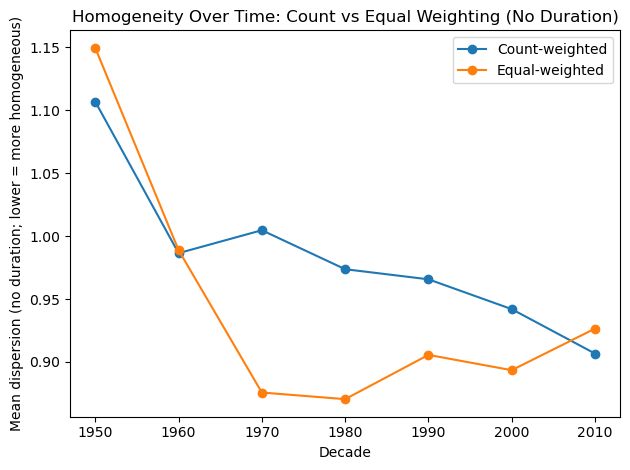

   decade  dispersion_no_duration_count_weight  \
0    1950                             1.106868   
1    1960                             0.986465   
2    1970                             1.004694   
3    1980                             0.973708   
4    1990                             0.965674   
5    2000                             0.941968   
6    2010                             0.906661   

   dispersion_no_duration_equal_weight  
0                             1.149604  
1                             0.988886  
2                             0.875699  
3                             0.870422  
4                             0.905598  
5                             0.893448  
6                             0.926497  


In [71]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

need_cols = {"decade", "broad_genre", "n_songs", "dispersion_no_duration"}
missing = sorted(list(need_cols - set(cell_nd.columns)))
if missing:
    raise ValueError(
        f"`cell_nd` is missing required columns: {missing}. "
        "Run your 'no duration' robustness block first so `cell_nd` exists."
    )

cell_nd = cell_nd.copy()
cell_nd["w_in_decade_count"] = cell_nd["n_songs"] / cell_nd.groupby("decade")["n_songs"].transform("sum")

agg_count = (
    cell_nd.assign(wdisp=cell_nd["w_in_decade_count"] * cell_nd["dispersion_no_duration"])
    .groupby("decade", as_index=False)["wdisp"]
    .sum()
    .rename(columns={"wdisp": "dispersion_no_duration_count_weight"})
)


agg_equal = (
    cell_nd.groupby("decade", as_index=False)["dispersion_no_duration"]
    .mean()
    .rename(columns={"dispersion_no_duration": "dispersion_no_duration_equal_weight"})
)

agg_both = agg_count.merge(agg_equal, on="decade", how="outer").sort_values("decade")

plt.figure()
plt.plot(
    agg_both["decade"],
    agg_both["dispersion_no_duration_count_weight"],
    marker="o",
    label="Count-weighted"
)
plt.plot(
    agg_both["decade"],
    agg_both["dispersion_no_duration_equal_weight"],
    marker="o",
    label="Equal-weighted"
)
plt.xlabel("Decade")
plt.ylabel("Mean dispersion (no duration; lower = more homogeneous)")
plt.title("Homogeneity Over Time: Count vs Equal Weighting (No Duration)")
plt.legend()
plt.tight_layout()


try:
    os.makedirs(OUT_FIG_DIR, exist_ok=True)
    outpath = os.path.join(OUT_FIG_DIR, "fig_equal_vs_count_no_duration.png")
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    print(f"Saved figure -> {outpath}")
except NameError:
    print("OUT_FIG_DIR not defined; figure not saved (but displayed in notebook).")

plt.show()


print(agg_both)


In [72]:

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


need_cols = {"decade", "broad_genre", "n_songs", "dispersion_no_duration", "decade_centered"}
missing = sorted(list(need_cols - set(cell_nd.columns)))
if missing:
    raise ValueError(f"`cell_nd` is missing required columns: {missing}. Run the no-duration block first.")


df = cell_nd.copy()
df = df.dropna(subset=["dispersion_no_duration", "decade_centered", "broad_genre", "n_songs", "decade"]).reset_index(drop=True)
df = df[df["n_songs"] > 0].reset_index(drop=True)

formula = "dispersion_no_duration ~ decade_centered + C(broad_genre)"


m_ols = smf.ols(formula, data=df).fit(cov_type="HC3")

m_wls = smf.wls(
    formula, data=df, weights=df["n_songs"]
).fit(cov_type="HC3")

m_wls_cluster = smf.wls(
    formula, data=df, weights=df["n_songs"]
).fit(cov_type="cluster", cov_kwds={"groups": df["decade"]})

m_wls_sqrt = smf.wls(
    formula, data=df, weights=np.sqrt(df["n_songs"])
).fit(cov_type="HC3")


print("\n" + "="*80)
print("MODEL 1: OLS (equal-weighted), HC3")
print("="*80)
print(m_ols.summary())

print("\n" + "="*80)
print("MODEL 2: WLS (count-weighted), HC3")
print("="*80)
print(m_wls.summary())

print("\n" + "="*80)
print("MODEL 3: WLS (count-weighted), Clustered SEs by decade")
print("="*80)
print(m_wls_cluster.summary())

print("\n" + "="*80)
print("MODEL 4: WLS (sqrt count-weighted), HC3")
print("="*80)
print(m_wls_sqrt.summary())


def extract_row(res, label, weighting, se_type, term="decade_centered"):
    return {
        "Model": label,
        "Weighting": weighting,
        "SE type": se_type,
        "beta_decade": float(res.params[term]),
        "SE_decade": float(res.bse[term]),
        "p_decade": float(res.pvalues[term]),
        "N": int(res.nobs),
        "R2": float(res.rsquared) if hasattr(res, "rsquared") else np.nan,
    }

robust_table = pd.DataFrame([
    extract_row(m_ols, "OLS (equal-weighted)", "None", "HC3"),
    extract_row(m_wls, "WLS (count-weighted)", "n_songs", "HC3"),
    extract_row(m_wls_cluster, "WLS (count-weighted)", "n_songs", "Clustered by decade"),
    extract_row(m_wls_sqrt, "WLS (sqrt count-weighted)", "sqrt(n_songs)", "HC3"),
])


display_table = robust_table.copy()
for c in ["beta_decade", "SE_decade", "p_decade", "R2"]:
    display_table[c] = display_table[c].round(5)

print("\n" + "="*80)
print("APPENDIX ROBUSTNESS TABLE (PLAIN OUTPUT)")
print("="*80)
print(display_table.to_string(index=False))


tmp = df.copy()


tmp["w_in_decade"] = tmp["n_songs"] / tmp.groupby("decade")["n_songs"].transform("sum")
agg_count = (
    tmp.assign(wdisp=tmp["dispersion_no_duration"] * tmp["w_in_decade"])
       .groupby("decade", as_index=False)["wdisp"]
       .sum()
       .rename(columns={"wdisp": "dispersion_no_duration_count_weight"})
)


agg_equal = (
    tmp.groupby("decade", as_index=False)["dispersion_no_duration"]
       .mean()
       .rename(columns={"dispersion_no_duration": "dispersion_no_duration_equal_weight"})
)

agg_compare = agg_count.merge(agg_equal, on="decade", how="inner").sort_values("decade")
agg_compare_display = agg_compare.copy()
agg_compare_display["dispersion_no_duration_count_weight"] = agg_compare_display["dispersion_no_duration_count_weight"].round(5)
agg_compare_display["dispersion_no_duration_equal_weight"] = agg_compare_display["dispersion_no_duration_equal_weight"].round(5)

print("\n" + "="*80)
print("DECADE AGGREGATES (NO DURATION): COUNT-WEIGHT vs EQUAL-WEIGHT")
print("="*80)
print(agg_compare_display.to_string(index=False))



MODEL 1: OLS (equal-weighted), HC3
                              OLS Regression Results                              
Dep. Variable:     dispersion_no_duration   R-squared:                       0.619
Model:                                OLS   Adj. R-squared:                  0.541
Method:                     Least Squares   F-statistic:                     35.81
Date:                    Thu, 15 Jan 2026   Prob (F-statistic):           1.24e-15
Time:                            11:07:41   Log-Likelihood:                 47.879
No. Observations:                      48   AIC:                            -77.76
Df Residuals:                          39   BIC:                            -60.92
Df Model:                               8                                         
Covariance Type:                      HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  warnings.warn('covariance of constraints does not have full '
